# Test full calculation
Test the full calculation of the 

## Import packages

In [1]:
%matplotlib inline
import xarray as xr
import s3fs
import zarr

import util
import xmip.preprocessing as xmip_pp

In [2]:
from dask_gateway import Gateway
gateway = Gateway()

In [3]:
##A line of trick to clean your dask cluster before you start your computation
from dask.distributed import Client
clusters=gateway.list_clusters()
print(clusters )
for cluster in clusters :
    cluster= gateway.connect(cluster.name)
    print(cluster)
    client = Client(cluster)
    client.close()
    cluster.shutdown()

[ClusterReport<name=daskhub.68a0b2a6dc46463cbd804df93a8b997d, status=RUNNING>]
GatewayCluster<daskhub.68a0b2a6dc46463cbd804df93a8b997d, status=running>


/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


### Create a new Dask cluster with the Dask Gateway

In [4]:
cluster = gateway.new_cluster(worker_memory=2, worker_cores=1)

cluster.scale(8)
cluster

### Get a client from the Dask Gateway Cluster

As stated above, creating a Dask `Client` is mandatory in order to perform following Daks computations on your Dask Cluster.

In [5]:
from distributed import Client

if cluster:
    client = Client(cluster) # create a dask Gateway cluster
else:
    client = Client()   # create a local dask cluster on the machine.
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /jupyterhub/services/dask-gateway/clusters/daskhub.847ff9ccef2e443bb5bc129b638fa58d/status,


## Summary of some test data

| model name | resolution | years in file for one variable | file size (one variable) | combined 3D variable data size | combined 2D variable data size |
| --- | --- | --- | --- | --- | --- |
| ACCESS-OM2 | 100 km | 10 | 670 MB | 17 GB | 0.4 GB |
| ACCESS-OM2-025 | 25 km | 1 | 1.1 GB | 271 GB | 7 GB |
| CMCC-CM2-SR5 | 100 km | 61 | 3.6 GB | 15 GB | 0.4 GB |
| CMCC-CM2-HR4 | 25 km | 10 | 9.4 GB | 231 GB | 6 GB |

## Load data from ESGF

In [20]:
sim_name = 'FGOALS-f3-L'
# 'FGOALS-f3-L'

In [21]:
result = util.esgf_search(activity_id='OMIP'
                          , experiment_id='omip2'
                          , variable_id='vmo'
                          , source_id=sim_name)
                          # works, source_id='ACCESS-OM2')
#CMCC-CM2-SR5')

https://esgf-node.llnl.gov/esg-search/search/?activity_id=OMIP&experiment_id=omip2&variable_id=vmo&source_id=FGOALS-f3-L&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=OMIP&experiment_id=omip2&variable_id=vmo&source_id=FGOALS-f3-L&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10


In [22]:
# pick one file for testing
files_to_open = [result[-1]]

In [23]:
ds = xr.open_mfdataset(files_to_open, combine='by_coords',chunks={'j':150,'i':150})

In [24]:
ds=ds.persist()
ds

<xarray.Dataset>
Dimensions:    (time: 732, bnds: 2, lev: 30, j: 218, i: 360)
Coordinates:
  * time       (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:00:00
  * lev        (lev) float64 5.0 15.0 25.0 ... 3.856e+03 4.538e+03 5.244e+03
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 210 211 212 213 214 215 216 217
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float64 dask.array<chunksize=(150, 150), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(150, 150), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(732, 2), meta=np.ndarray>
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(30, 2), meta=np.ndarray>
    vmo        (time, lev, j, i) float32 dask.array<chunksize=(732, 30, 150, 150), meta=np.ndarray>
Attributes: (12/41)
    Conventions:                     CF-1.7 CMIP-6.2
    Input_files:                     OMIP_data_linpf/OMIP2.nc
    activity_id:                     OMIP
    contact:                         Pengfei Lin(linpf@mail.iap.ac.cn)
    creation_date:                   2019-12-17T08:32:00Z
    data_specs_version:              01.00.30
    ...                              ...
    tracking_id:                     hdl:21.14100/e08b49cc-8144-4ce1-8315-6d6...
    variable_id:                     vmo
    variant_label:                   r1i1p1f1
    license:                         CMIP6 model data produced by LASG, Insti...
    cmor_version:                    3.4.0
    DODS_EXTRA.Unlimited_Dimension:  time

## Test the right order of preprocessing

In [25]:
ds = util.model_preproc(ds)
ds

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xmip-0.6.1rc1.dev11+g37985f0-py3.9.egg/xmip/preprocessing.py:291: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")


<xarray.Dataset>
Dimensions:      (time: 732, lev: 30, y: 218, x: 360, bnds: 2)
Coordinates:
  * time         (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:00:00
  * lev          (lev) float64 5.0 15.0 25.0 ... 3.856e+03 4.538e+03 5.244e+03
  * y            (y) int32 0 1 2 3 4 5 6 7 8 ... 210 211 212 213 214 215 216 217
  * x            (x) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    time_bounds  (time, bnds) object dask.array<chunksize=(732, 2), meta=np.ndarray>
    lev_bounds   (lev, bnds) float64 dask.array<chunksize=(30, 2), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(68, 150), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(68, 150), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    vmo          (time, lev, y, x) float32 dask.array<chunksize=(732, 30, 68, 150), meta=np.ndarray>
Attributes: (12/41)
    Conventions:                     CF-1.7 CMIP-6.2
    Input_files:                     OMIP_data_linpf/OMIP2.nc
    activity_id:                     OMIP
    contact:                         Pengfei Lin(linpf@mail.iap.ac.cn)
    creation_date:                   2019-12-17T08:32:00Z
    data_specs_version:              01.00.30
    ...                              ...
    tracking_id:                     hdl:21.14100/e08b49cc-8144-4ce1-8315-6d6...
    variable_id:                     vmo
    variant_label:                   r1i1p1f1
    license:                         CMIP6 model data produced by LASG, Insti...
    cmor_version:                    3.4.0
    DODS_EXTRA.Unlimited_Dimension:  time

## Subset Pan-Arctic (lat>50N)

In [27]:
cond = (ds['lat']>=50)

In [28]:
dsnow = ds.where(cond,drop=True).persist()

In [29]:
dsnow = dsnow.chunk(chunks={'x':150,'y':150}).persist()

In [30]:
dsnow

<xarray.Dataset>
Dimensions:      (time: 732, lev: 30, y: 36, x: 360, bnds: 2)
Coordinates:
  * time         (time) object 1958-01-16 12:00:00 ... 2018-12-16 12:00:00
  * lev          (lev) float64 5.0 15.0 25.0 ... 3.856e+03 4.538e+03 5.244e+03
  * y            (y) int32 182 183 184 185 186 187 ... 212 213 214 215 216 217
  * x            (x) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    time_bounds  (time, bnds) object dask.array<chunksize=(732, 2), meta=np.ndarray>
    lev_bounds   (lev, bnds) float64 dask.array<chunksize=(30, 2), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(36, 150), meta=np.ndarray>
    lon          (y, x) float64 dask.array<chunksize=(36, 150), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    vmo          (time, lev, y, x) float32 dask.array<chunksize=(732, 30, 36, 150), meta=np.ndarray>
Attributes: (12/41)
    Conventions:                     CF-1.7 CMIP-6.2
    Input_files:                     OMIP_data_linpf/OMIP2.nc
    activity_id:                     OMIP
    contact:                         Pengfei Lin(linpf@mail.iap.ac.cn)
    creation_date:                   2019-12-17T08:32:00Z
    data_specs_version:              01.00.30
    ...                              ...
    tracking_id:                     hdl:21.14100/e08b49cc-8144-4ce1-8315-6d6...
    variable_id:                     vmo
    variant_label:                   r1i1p1f1
    license:                         CMIP6 model data produced by LASG, Insti...
    cmor_version:                    3.4.0
    DODS_EXTRA.Unlimited_Dimension:  time

In [28]:
your_name='malberty'
path='WAFFLES/'+your_name
s3_prefix =  "s3://"+path
print(s3_prefix)
access_key = !aws configure get aws_access_key_id
access_key = access_key[0]
secret_key = !aws configure get aws_secret_access_key
secret_key = secret_key[0]
client_kwargs={'endpoint_url': 'https://object-store.cloud.muni.cz'}

s3://WAFFLES/malberty


In [29]:
target = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://object-store.cloud.muni.cz'
      })
target.ls(path)

[]

In [ ]:
target.rm(path,recursive=True)

In [31]:
zarr_file_name= f'test_{sim_name}'
uri = f"{s3_prefix}/{zarr_file_name}"
store = zarr.storage.FSStore(uri, client_kwargs=client_kwargs,key=access_key, secret=secret_key)
store.map.fs.find(uri)

[]

In [32]:
%time dsnow.to_zarr(store=store, mode='w', consolidated=True)

CPU times: user 3min 34s, sys: 1.16 s, total: 3min 35s
Wall time: 6min 26s


In [33]:
test=xr.open_zarr(store=store)#consolidated=True)
test

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.Dataset>
Dimensions:      (y: 350, x: 1440, vertex: 4, lev: 50, bnds: 2, time: 12)
Coordinates:
    lat          (y, x) float64 dask.array<chunksize=(150, 150), meta=np.ndarray>
  * lev          (lev) float64 1.152 3.649 6.565 ... 5.034e+03 5.254e+03
    lon          (y, x) float64 dask.array<chunksize=(150, 150), meta=np.ndarray>
  * time         (time) object 0366-01-16 12:00:00 ... 0366-12-16 12:00:00
  * x            (x) int32 0 1 2 3 4 5 6 ... 1433 1434 1435 1436 1437 1438 1439
  * y            (y) int32 730 731 732 733 734 735 ... 1075 1076 1077 1078 1079
Dimensions without coordinates: vertex, bnds
Data variables:
    lat_bounds   (y, x, vertex) float64 dask.array<chunksize=(150, 150, 4), meta=np.ndarray>
    lev_bounds   (lev, bnds, y, x) float64 dask.array<chunksize=(50, 2, 150, 150), meta=np.ndarray>
    lon_bounds   (y, x, vertex) float64 dask.array<chunksize=(150, 150, 4), meta=np.ndarray>
    time_bounds  (time, bnds, y, x) object dask.array<chunksize=(3, 1, 88, 720), meta=np.ndarray>
    vmo          (time, lev, y, x) float32 dask.array<chunksize=(12, 50, 150, 150), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                     CF-1.7 CMIP-6.2
    DODS_EXTRA.Unlimited_Dimension:  time
    activity_id:                     OMIP
    branch_method:                   no parent
    branch_time_in_child:            0.0
    branch_time_in_parent:           0.0
    ...                              ...
    table_info:                      Creation Date:(30 April 2019) MD5:12ec21...
    title:                           ACCESS-OM2-025 output prepared for CMIP6
    tracking_id:                     hdl:21.14100/d0cba987-c5c7-42fc-a310-ae1...
    variable_id:                     vmo
    variant_label:                   r1i1p1f1
    version:                         v20210617

In [34]:
test.y.compute()

<xarray.DataArray 'y' (y: 350)>
array([ 730,  731,  732, ..., 1077, 1078, 1079], dtype=int32)
Coordinates:
  * y        (y) int32 730 731 732 733 734 735 ... 1074 1075 1076 1077 1078 1079
Attributes:
    long_name:  cell index along second dimension
    units:      1

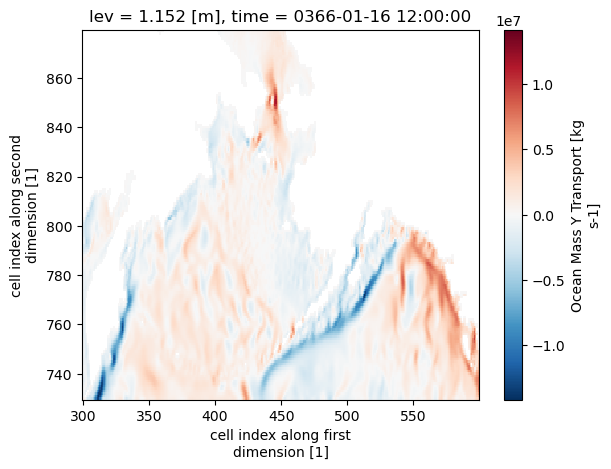

In [41]:
test.vmo.isel(x=slice(300,600),y=slice(0,150),time=0,lev=0).plot()

## Extract Berring Strait

## Calc Volume Transport